In [1]:
import ipyparallel
import hddm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print(hddm.__version__)

0.8.0


/home/jasongong/.local/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


### Load the data

In [200]:
# read the data to pandas dataframe
data = hddm.load_csv('s3_hddm_cleaned.csv')

In [201]:
# flip RTs of choosing lower value options to negative RTs
data = hddm.utils.flip_errors(data)
data

,Unnamed: 0,subj_idx,participant,stim,rt,response,raw_response,group,trial,arousal,valence,age,gender,language
0,1,0,5f4ea4e40574e70cb7d2ff0c,0V0A,5.9379,1,1,group2,11,2,3,22,Female,Yes
1,2,0,5f4ea4e40574e70cb7d2ff0c,0V0A,3.0848,1,1,group2,15,2,3,22,Female,Yes
2,3,0,5f4ea4e40574e70cb7d2ff0c,0V0A,3.2170,1,1,group2,19,2,3,22,Female,Yes
3,4,0,5f4ea4e40574e70cb7d2ff0c,0V0A,8.7357,1,1,group2,20,2,3,22,Female,Yes
4,5,0,5f4ea4e40574e70cb7d2ff0c,0V0A,1.4293,1,1,group2,30,2,3,22,Female,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42135,42136,324,5e5ae01d75f13d2efe7db45e,1Vne1A,5.0453,1,1,group2,115,3,3,72,Male,Yes
42136,42137,324,5e5ae01d75f13d2efe7db45e,1Vne1A,3.4706,1,2,group2,123,3,4,72,Male,Yes
42137,42138,324,5e5ae01d75f13d2efe7db45e,1Vne1A,3.7842,1,1,group2,134,3,4,72,Male,Yes
42138,42139,324,5e5ae01d75f13d2efe7db45e,1Vne1A,5.2521,1,2,group2,136,3,4,72,Male,Yes


Text(0.5, 0.04, 'Study 3')

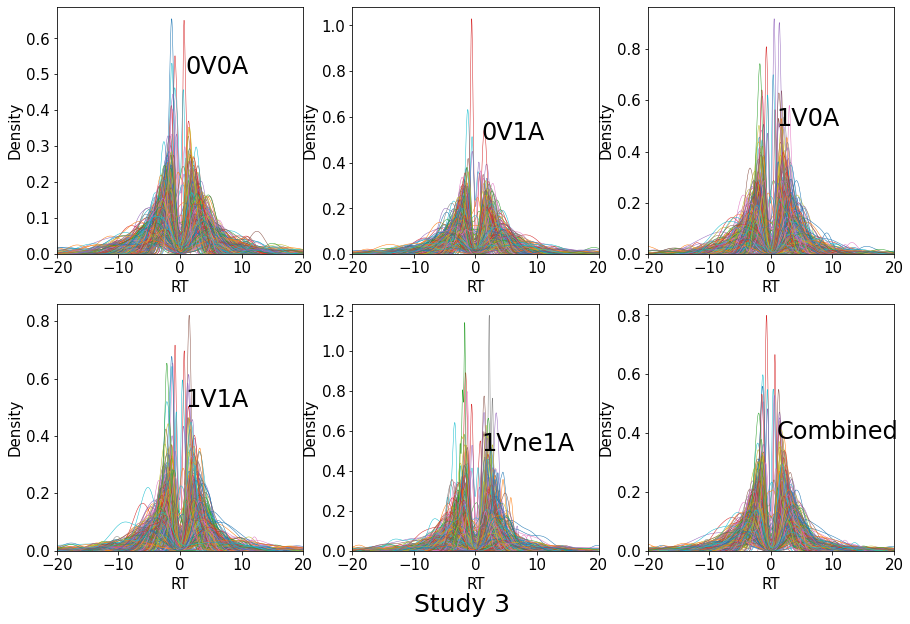

In [203]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

k = 0
for i, stim_data in data.groupby('stim'):
    
    ax[k//3, k%3].set_xlim([-20, 20])
    ax[k//3, k%3].set_xlabel("RT", fontsize=15)
    ax[k//3, k%3].set_ylabel("Density", fontsize=15)
    ax[k//3, k%3].text(0.9, 0.5, i, fontsize=24)
    
    for j, subj_data in stim_data.groupby('subj_idx'):
        sns.kdeplot(subj_data.rt, fill = False,bw_adjust=.4,
                    linewidth=0.5,alpha=0.1, ax=ax[k//3, k%3])
        
    k = k + 1

ax[1, 2].set_xlim([-20, 20])
ax[1, 2].set_xlabel("RT", fontsize=15)
ax[1, 2].set_ylabel("Density", fontsize=15)
ax[1, 2].text(0.9, 0.38, "Combined", fontsize=24)
for j, subj_data in data.groupby('subj_idx'):
    sns.kdeplot(subj_data.rt, fill = False,bw_adjust=.4,
                linewidth=0.5,alpha=0.1, ax=ax[1,2])

fig.text(0.5, 0.04, 'Study 3', ha='center', fontsize=25)

In [5]:
data.stim.unique()

array(['0V0A', '0V1A', '1V0A', '1V1A', '1Vne1A'], dtype=object)

In [6]:
# code the induction group of each subject into 2*2 between-subject variables
# mood_valence & mood_arousal
# code the decision tasks into 2*2 within-subject variables
# movie_valence & movie_arousal

data = data.drop(data[data.stim == '1Vne1A'].index)
data['movie_valence'] = data.stim.str[:1]
data['movie_arousal'] = data.stim.str[-2:-1]
di = {'group1': "1V1A", 'group2': "1V0A", 'group3': "0V1A", 'group4': "0V0A"}
data['group_code'] = data.group
data = data.replace({"group": di})
data['mood_valence'] = data.group.str[:1]
data['mood_arousal'] = data.group.str[-2:-1]

In [7]:
np.random.seed(123)
data.loc[data.stim == "0V0A", "response"] = np.random.choice([0,1], data[data.stim == "0V0A"].response.shape[0])
data = hddm.utils.flip_errors(data)

In [85]:
data.subj_idx.unique().shape

(301,)

In [198]:
data.drop_duplicates("participant").group_code.value_counts()

group2    79
group3    78
group1    73
group4    71
Name: group_code, dtype: int64

# FULL Regression Model Fixed Model

# Confirmatory Analysis

In [9]:
# sepecify the HDDM regression model
# include four decision parameters: 
# drift rate: v; decision boundary: a; non-decision time: t; decision bias: z
# specify mixture model with 5% of the RTs as contations RT from a uniform distribution

m_FULL_hypothesis = hddm.HDDMRegressor(data, ["v ~  movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal",
                                   "a ~ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal",
                                   "t ~ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal",
                                   "z ~ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal"],
                            include=('v', 'a', 't', 'z'),
                            p_outlier=0.05)

Adding these covariates:
['v_Intercept', 'v_movie_valence[T.1]', 'v_movie_arousal[T.1]', 'v_mood_valence[T.1]', 'v_mood_arousal[T.1]', 'v_movie_valence[T.1]:mood_valence[T.1]', 'v_movie_arousal[T.1]:mood_arousal[T.1]']
Adding these covariates:
['a_Intercept', 'a_movie_valence[T.1]', 'a_movie_arousal[T.1]', 'a_mood_valence[T.1]', 'a_mood_arousal[T.1]', 'a_movie_valence[T.1]:mood_valence[T.1]', 'a_movie_arousal[T.1]:mood_arousal[T.1]']
Adding these covariates:
['t_Intercept', 't_movie_valence[T.1]', 't_movie_arousal[T.1]', 't_mood_valence[T.1]', 't_mood_arousal[T.1]', 't_movie_valence[T.1]:mood_valence[T.1]', 't_movie_arousal[T.1]:mood_arousal[T.1]']
Adding these covariates:
['z_Intercept', 'z_movie_valence[T.1]', 'z_movie_arousal[T.1]', 'z_mood_valence[T.1]', 'z_mood_arousal[T.1]', 'z_movie_valence[T.1]:mood_valence[T.1]', 'z_movie_arousal[T.1]:mood_arousal[T.1]']


In [ ]:
m_FULL_hypothesis.find_starting_values()

# start sampling MCMC chains
# start drawing 10000 samples, with 2000 as burn-in samples
# save the fitting data into a bd file
m_FULL_hypothesis.sample(10000, burn=1000, dbname='study3_regression_full_hypothesis_original.db', db='pickle')

# save the model
m_FULL_hypothesis.save('study3_regression_full_hypothesis_original')

In [9]:
# get the MCMC fitting nodes of each parameters in the model
s3_full_v_movie_valence,\
s3_full_v_movie_arousal,\
s3_full_v_mood_valence,\
s3_full_v_mood_arousal,\
s3_full_v_movie_valence_mood_valence,\
s3_full_v_movie_arousal_mood_arousal,\
s3_full_a_movie_valence,\
s3_full_a_movie_arousal,\
s3_full_a_mood_valence,\
s3_full_a_mood_arousal,\
s3_full_a_movie_valence_mood_valence,\
s3_full_a_movie_arousal_mood_arousal,\
s3_full_t_movie_valence,\
s3_full_t_movie_arousal,\
s3_full_t_mood_valence,\
s3_full_t_mood_arousal,\
s3_full_t_movie_valence_mood_valence,\
s3_full_t_movie_arousal_mood_arousal,\
s3_full_z_movie_valence,\
s3_full_z_movie_arousal,\
s3_full_z_mood_valence,\
s3_full_z_mood_arousal,\
s3_full_z_movie_valence_mood_valence,\
s3_full_z_movie_arousal_mood_arousal = m_FULL_hypothesis.nodes_db.loc[[
    "v_movie_valence[T.1]",
    "v_movie_arousal[T.1]",
    "v_mood_valence[T.1]",
    "v_mood_arousal[T.1]",
    "v_movie_valence[T.1]:mood_valence[T.1]",
    "v_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "a_movie_valence[T.1]",
    "a_movie_arousal[T.1]",
    "a_mood_valence[T.1]",
    "a_mood_arousal[T.1]",
    "a_movie_valence[T.1]:mood_valence[T.1]",
    "a_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "t_movie_valence[T.1]",
    "t_movie_arousal[T.1]",
    "t_mood_valence[T.1]",
    "t_mood_arousal[T.1]",
    "t_movie_valence[T.1]:mood_valence[T.1]",
    "t_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "z_movie_valence[T.1]",
    "z_movie_arousal[T.1]",
    "z_mood_valence[T.1]",
    "z_mood_arousal[T.1]",
    "z_movie_valence[T.1]:mood_valence[T.1]",
    "z_movie_arousal[T.1]:mood_arousal[T.1]",
    ], 'node']

In [42]:
s3_original_stats = m_FULL_hypothesis.gen_stats()

In [44]:
s3_original_stats.loc[s3_original_stats.index.isin(["v_movie_valence[T.1]",
    "v_movie_arousal[T.1]",
    "v_mood_valence[T.1]",
    "v_mood_arousal[T.1]",
    "v_movie_valence[T.1]:mood_valence[T.1]",
    "v_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "a_movie_valence[T.1]",
    "a_movie_arousal[T.1]",
    "a_mood_valence[T.1]",
    "a_mood_arousal[T.1]",
    "a_movie_valence[T.1]:mood_valence[T.1]",
    "a_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "t_movie_valence[T.1]",
    "t_movie_arousal[T.1]",
    "t_mood_valence[T.1]",
    "t_mood_arousal[T.1]",
    "t_movie_valence[T.1]:mood_valence[T.1]",
    "t_movie_arousal[T.1]:mood_arousal[T.1]",
    
    "z_movie_valence[T.1]",
    "z_movie_arousal[T.1]",
    "z_mood_valence[T.1]",
    "z_mood_arousal[T.1]",
    "z_movie_valence[T.1]:mood_valence[T.1]",
    "z_movie_arousal[T.1]:mood_arousal[T.1]"]), ["mean", "std", "2.5q", "97.5q"]]

,mean,std,2.5q,97.5q
v_movie_valence[T.1],-0.024202,0.014289,-0.051197,0.003655
v_movie_arousal[T.1],0.000236,0.013789,-0.026016,0.027617
v_mood_valence[T.1],-0.03966,0.023556,-0.087021,0.008589
v_mood_arousal[T.1],-0.003244,0.022472,-0.046436,0.040884
v_movie_valence[T.1]:mood_valence[T.1],0.014514,0.020494,-0.024441,0.055491
v_movie_arousal[T.1]:mood_arousal[T.1],0.026997,0.019925,-0.011486,0.066535
a_movie_valence[T.1],-0.118845,0.025319,-0.16705,-0.068407
a_movie_arousal[T.1],-0.025103,0.023851,-0.07048,0.022076
a_mood_valence[T.1],-0.015721,0.055767,-0.120828,0.098591
a_mood_arousal[T.1],-0.01663,0.070779,-0.146657,0.126987


In [30]:
def inference_test(trace):
    probability1 = round((trace < 0).mean(), 3) 
    probability2 = round((1-probability1), 3) 
    return "{} % < 0 < {} %".format(probability1 * 100, probability2 * 100)

In [34]:
{"v movie valence": inference_test(s3_full_v_movie_valence.trace()), 
            "v movie arousal": inference_test(s3_full_v_movie_arousal.trace()),
            "v mood valence": inference_test(s3_full_v_mood_valence.trace()), 
            "v mood arousal": inference_test(s3_full_v_mood_arousal.trace()),
            "v mood movie valence": inference_test(s3_full_v_movie_valence_mood_valence.trace()), 
            "v mood movie arousal": inference_test(s3_full_v_movie_arousal_mood_arousal.trace()),
           
            "a movie valence": inference_test(s3_full_a_movie_valence.trace()), 
            "a movie arousal": inference_test(s3_full_a_movie_arousal.trace()),
            "a mood valence": inference_test(s3_full_a_mood_valence.trace()), 
            "a mood arousal": inference_test(s3_full_a_mood_arousal.trace()),
            "a mood movie valence": inference_test(s3_full_a_movie_valence_mood_valence.trace()), 
            "a mood movie arousal": inference_test(s3_full_a_movie_arousal_mood_arousal.trace()),
            
            "t movie valence": inference_test(s3_full_t_movie_valence.trace()), 
            "t movie arousal": inference_test(s3_full_t_movie_arousal.trace()),
            "t mood valence": inference_test(s3_full_t_mood_valence.trace()), 
            "t mood arousal": inference_test(s3_full_t_mood_arousal.trace()),
            "t mood movie valence": inference_test(s3_full_t_movie_valence_mood_valence.trace()), 
            "t mood movie arousal": inference_test(s3_full_t_movie_arousal_mood_arousal.trace()),
            
            "z movie valence": inference_test(s3_full_z_movie_valence.trace()), 
            "z movie arousal": inference_test(s3_full_z_movie_arousal.trace()),
            "z mood valence": inference_test(s3_full_z_mood_valence.trace()), 
            "z mood arousal": inference_test(s3_full_z_mood_arousal.trace()),
            "z mood movie valence": inference_test(s3_full_z_movie_valence_mood_valence.trace()), 
            "z mood movie arousal": inference_test(s3_full_z_movie_arousal_mood_arousal.trace()),}

{'v movie valence': '95.1 % < 0 < 4.9 %',
 'v movie arousal': '56.00000000000001 % < 0 < 44.0 %',
 'v mood valence': '96.89999999999999 % < 0 < 3.1 %',
 'v mood arousal': '61.3 % < 0 < 38.7 %',
 'v mood movie valence': '24.2 % < 0 < 75.8 %',
 'v mood movie arousal': '7.000000000000001 % < 0 < 93.0 %',
 'a movie valence': '100.0 % < 0 < 0.0 %',
 'a movie arousal': '85.7 % < 0 < 14.299999999999999 %',
 'a mood valence': '63.3 % < 0 < 36.7 %',
 'a mood arousal': '66.2 % < 0 < 33.800000000000004 %',
 'a mood movie valence': '33.5 % < 0 < 66.5 %',
 'a mood movie arousal': '30.599999999999998 % < 0 < 69.39999999999999 %',
 't movie valence': '49.9 % < 0 < 50.1 %',
 't movie arousal': '81.10000000000001 % < 0 < 18.9 %',
 't mood valence': '87.9 % < 0 < 12.1 %',
 't mood arousal': '73.4 % < 0 < 26.6 %',
 't mood movie valence': '71.2 % < 0 < 28.799999999999997 %',
 't mood movie arousal': '96.8 % < 0 < 3.2 %',
 'z movie valence': '3.0 % < 0 < 97.0 %',
 'z movie arousal': '3.8 % < 0 < 96.2 %',


In [60]:
inference_test(s3_full_v_movie_arousal_mood_arousal.trace() -s3_full_v_movie_valence_mood_valence.trace())

'29.599999999999998 % < 0 < 70.39999999999999 %'

In [52]:
v_movie_valence = s3_full_v_movie_valence.trace() 
v_movie_arousal = s3_full_v_movie_arousal.trace()
v_mood_valence = s3_full_v_mood_valence.trace() 
v_mood_arousal = s3_full_v_mood_arousal.trace()
v_movie_valence_mood_valence = s3_full_v_movie_valence_mood_valence.trace()
v_movie_arousal_mood_arousal = s3_full_v_movie_arousal_mood_arousal.trace()

a_movie_valence = s3_full_a_movie_valence.trace() 
a_movie_arousal = s3_full_a_movie_arousal.trace()
a_mood_valence = s3_full_a_mood_valence.trace() 
a_mood_arousal = s3_full_a_mood_arousal.trace()
a_movie_valence_mood_valence = s3_full_a_movie_valence_mood_valence.trace()
a_movie_arousal_mood_arousal = s3_full_a_movie_arousal_mood_arousal.trace()


t_movie_valence = s3_full_t_movie_valence.trace() 
t_movie_arousal = s3_full_t_movie_arousal.trace()
t_mood_valence = s3_full_t_mood_valence.trace() 
t_mood_arousal = s3_full_t_mood_arousal.trace()
t_movie_valence_mood_valence = s3_full_t_movie_valence_mood_valence.trace()
t_movie_arousal_mood_arousal = s3_full_t_movie_arousal_mood_arousal.trace()


z_movie_valence = s3_full_z_movie_valence.trace() 
z_movie_arousal = s3_full_z_movie_arousal.trace()
z_mood_valence = s3_full_z_mood_valence.trace() 
z_mood_arousal = s3_full_z_mood_arousal.trace()
z_movie_valence_mood_valence = s3_full_z_movie_valence_mood_valence.trace()
z_movie_arousal_mood_arousal = s3_full_z_movie_arousal_mood_arousal.trace()

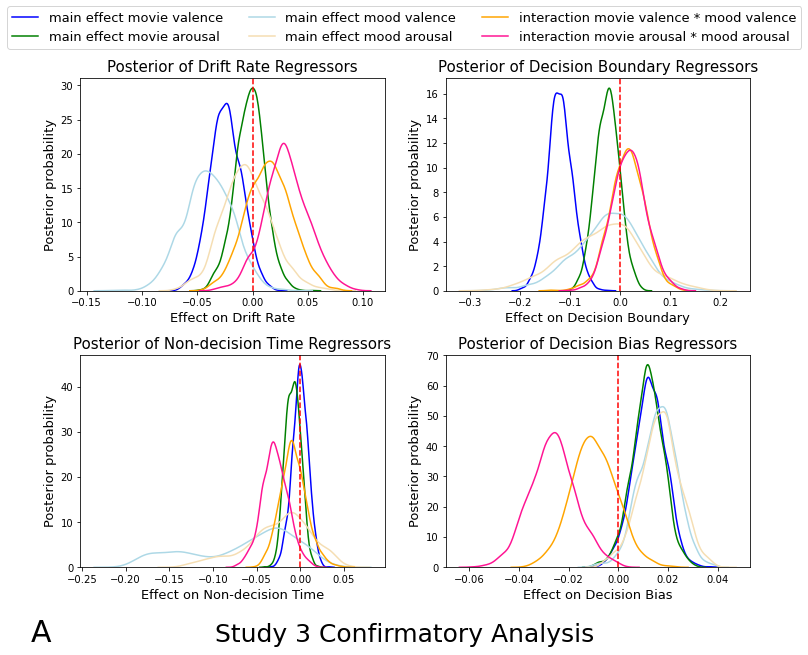

In [61]:
fig, ax = plt.subplots(2,2,figsize=(12,9))


sns.kdeplot(v_movie_valence,ax=ax[0,0], label="main effect movie valence", color='b')
sns.kdeplot(v_movie_arousal,ax=ax[0,0], label="main effect movie arousal", color='green')
sns.kdeplot(v_mood_valence,ax=ax[0,0], label="main effect mood valence", color='lightblue')
sns.kdeplot(v_mood_arousal,ax=ax[0,0], label="main effect mood arousal", color='wheat')
sns.kdeplot(v_movie_valence_mood_valence,ax=ax[0,0], label="interaction movie valence * mood valence", color='orange')
sns.kdeplot(v_movie_arousal_mood_arousal,ax=ax[0,0], label="interaction movie arousal * mood arousal", color='deeppink')

ax[0,0].axvline(x=0,c = 'r', ls='--')
ax[0,0].set_xlabel('Effect on Drift Rate', fontsize=13)
ax[0,0].set_ylabel('Posterior probability', fontsize=13)
ax[0,0].set_title('Posterior of Drift Rate Regressors', fontsize=15)


sns.kdeplot(a_movie_valence,ax=ax[0,1], label="main effect movie valence", color='b')
sns.kdeplot(a_movie_arousal,ax=ax[0,1], label="main effect movie arousal", color='green')
sns.kdeplot(a_mood_valence,ax=ax[0,1], label="main effect mood valence", color='lightblue')
sns.kdeplot(a_mood_arousal,ax=ax[0,1], label="main effect mood arousal", color='wheat')
sns.kdeplot(a_movie_valence_mood_valence,ax=ax[0,1], label="interaction movie valence * mood valence", color='orange')
sns.kdeplot(a_movie_arousal_mood_arousal,ax=ax[0,1], label="interaction movie arousal * mood arousal", color='deeppink')

ax[0,1].axvline(x=0,c = 'r', ls='--')
ax[0,1].set_xlabel('Effect on Decision Boundary', fontsize=13)
ax[0,1].set_ylabel('Posterior probability', fontsize=13)
ax[0,1].set_title('Posterior of Decision Boundary Regressors', fontsize=15)


sns.kdeplot(t_movie_valence,ax=ax[1,0], label="main effect movie valence", color='b')
sns.kdeplot(t_movie_arousal,ax=ax[1,0], label="main effect movie arousal", color='green')
sns.kdeplot(t_mood_valence,ax=ax[1,0], label="main effect mood valence", color='lightblue')
sns.kdeplot(t_mood_arousal,ax=ax[1,0], label="main effect mood arousal", color='wheat')
sns.kdeplot(t_movie_valence_mood_valence,ax=ax[1,0], label="interaction movie valence * mood valence", color='orange')
sns.kdeplot(t_movie_arousal_mood_arousal,ax=ax[1,0], label="interaction movie arousal * mood arousal", color='deeppink')

ax[1,0].axvline(x=0,c = 'r', ls='--')
ax[1,0].set_xlabel('Effect on Non-decision Time', fontsize=13)
ax[1,0].set_ylabel('Posterior probability', fontsize=13)
ax[1,0].set_title('Posterior of Non-decision Time Regressors', fontsize=15)


sns.kdeplot(z_movie_valence,ax=ax[1,1], label="main effect movie valence", color='b')
sns.kdeplot(z_movie_arousal,ax=ax[1,1], label="main effect movie arousal", color='green')
sns.kdeplot(z_mood_valence,ax=ax[1,1], label="main effect mood valence", color='lightblue')
sns.kdeplot(z_mood_arousal,ax=ax[1,1], label="main effect mood arousal", color='wheat')
sns.kdeplot(z_movie_valence_mood_valence,ax=ax[1,1], label="interaction movie valence * mood valence", color='orange')
sns.kdeplot(z_movie_arousal_mood_arousal,ax=ax[1,1], label="interaction movie arousal * mood arousal", color='deeppink')

ax[1,1].axvline(x=0,c = 'r', ls='--')
ax[1,1].set_xlabel('Effect on Decision Bias', fontsize=13)
ax[1,1].set_ylabel('Posterior probability', fontsize=13)
ax[1,1].set_title('Posterior of Decision Bias Regressors', fontsize=15)


plt.subplots_adjust(wspace=0.2, hspace=.3)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size': 13})

fig.text(0.08, 0.01, 'A', ha='center',fontsize=30)
fig.text(0.5, 0.01, 'Study 3 Confirmatory Analysis', ha='center',fontsize=25)

plt.savefig('Figure4A.png', dpi=300)

# Exploratory Analysis

In [9]:
# sepecify the HDDM regression model
# include four decision parameters: 
# drift rate: v; decision boundary: a; non-decision time: t; decision bias: z
# specify mixture model with 5% of the RTs as contations RT from a uniform distribution

m_FULL_hypothesis_test = hddm.HDDMRegressor(data, ["v ~ movie_valence + movie_arousal"
                                   + "+ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal"
                                   + "+ movie_valence * age"
                                   + "+ movie_arousal * age",
                                   "a ~ movie_valence + movie_arousal"
                                   + "+ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal"
                                   + "+ movie_valence * age"
                                   + "+ movie_arousal * age",
                                   "t ~ movie_valence + movie_arousal"
                                   + "+ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal"
                                   + "+ movie_valence * age"
                                   + "+ movie_arousal * age",
                                   "z ~ movie_valence + movie_arousal"
                                   + "+ movie_valence * mood_valence"
                                   + "+ movie_arousal * mood_arousal"
                                   + "+ movie_valence * age"
                                   + "+ movie_arousal * age"],
                            include=('v', 'a', 't', 'z'),
                            p_outlier=0.05)

Adding these covariates:
['v_Intercept', 'v_movie_valence[T.1]', 'v_movie_arousal[T.1]', 'v_mood_valence[T.1]', 'v_mood_arousal[T.1]', 'v_movie_valence[T.1]:mood_valence[T.1]', 'v_movie_arousal[T.1]:mood_arousal[T.1]', 'v_age', 'v_movie_valence[T.1]:age', 'v_movie_arousal[T.1]:age']
Adding these covariates:
['a_Intercept', 'a_movie_valence[T.1]', 'a_movie_arousal[T.1]', 'a_mood_valence[T.1]', 'a_mood_arousal[T.1]', 'a_movie_valence[T.1]:mood_valence[T.1]', 'a_movie_arousal[T.1]:mood_arousal[T.1]', 'a_age', 'a_movie_valence[T.1]:age', 'a_movie_arousal[T.1]:age']
Adding these covariates:
['t_Intercept', 't_movie_valence[T.1]', 't_movie_arousal[T.1]', 't_mood_valence[T.1]', 't_mood_arousal[T.1]', 't_movie_valence[T.1]:mood_valence[T.1]', 't_movie_arousal[T.1]:mood_arousal[T.1]', 't_age', 't_movie_valence[T.1]:age', 't_movie_arousal[T.1]:age']
Adding these covariates:
['z_Intercept', 'z_movie_valence[T.1]', 'z_movie_arousal[T.1]', 'z_mood_valence[T.1]', 'z_mood_arousal[T.1]', 'z_movie_vale

In [ ]:
m_FULL_hypothesis_test.find_starting_values()

# start sampling MCMC chains
# start drawing 10000 samples, with 2000 as burn-in samples
# save the fitting data into a bd file
m_FULL_hypothesis_test.sample(10000, burn=1000, dbname='study3.db', db='pickle')

In [11]:
m_FULL_hypothesis_test.save('study3_age')

In [ ]:
# get the MCMC fitting nodes of each parameters in the model
s3_full_v_movie_valence,\
s3_full_v_mood_valence,\
s3_full_v_movie_arousal,\
s3_full_v_mood_arousal,\
s3_full_v_movie_valence_mood_valence,\
s3_full_v_movie_arousal_mood_arousal,\
s3_full_v_age,\
s3_full_v_movie_valence_age,\
s3_full_v_movie_arousal_age,\
s3_full_a_movie_valence,\
s3_full_a_mood_valence,\
s3_full_a_movie_arousal,\
s3_full_a_mood_arousal,\
s3_full_a_movie_valence_mood_valence,\
s3_full_a_movie_arousal_mood_arousal,\
s3_full_a_age,\
s3_full_a_movie_valence_age,\
s3_full_a_movie_arousal_age,\
s3_full_t_movie_valence,\
s3_full_t_mood_valence,\
s3_full_t_movie_arousal,\
s3_full_t_mood_arousal,\
s3_full_t_movie_valence_mood_valence,\
s3_full_t_movie_arousal_mood_arousal,\
s3_full_t_age,\
s3_full_t_movie_valence_age,\
s3_full_t_movie_arousal_age,\
s3_full_z_movie_valence,\
s3_full_z_mood_valence,\
s3_full_z_movie_arousal,\
s3_full_z_mood_arousal,\
s3_full_z_movie_valence_mood_valence,\
s3_full_z_movie_arousal_mood_arousal,\
s3_full_z_age,\
s3_full_z_movie_valence_age,\
s3_full_z_movie_arousal_age = m_FULL_hypothesis_test.nodes_db.loc[[
    "v_movie_valence[T.1]",
    "v_mood_valence[T.1]",
    "v_movie_arousal[T.1]",
    "v_mood_arousal[T.1]", 
    "v_movie_valence[T.1]:mood_valence[T.1]",
    "v_movie_arousal[T.1]:mood_arousal[T.1]",
    "v_age",
    "v_movie_valence[T.1]:age",
    "v_movie_arousal[T.1]:age",
    
    "a_movie_valence[T.1]",
    "a_mood_valence[T.1]",
    "a_movie_arousal[T.1]",
    "a_mood_arousal[T.1]", 
    "a_movie_valence[T.1]:mood_valence[T.1]",
    "a_movie_arousal[T.1]:mood_arousal[T.1]",
    "a_age",
    "a_movie_valence[T.1]:age",
    "a_movie_arousal[T.1]:age",
    
    "t_movie_valence[T.1]",
    "t_mood_valence[T.1]",
    "t_movie_arousal[T.1]",
    "t_mood_arousal[T.1]", 
    "t_movie_valence[T.1]:mood_valence[T.1]",
    "t_movie_arousal[T.1]:mood_arousal[T.1]",
    "t_age",
    "t_movie_valence[T.1]:age",
    "t_movie_arousal[T.1]:age",
    
    "z_movie_valence[T.1]",
    "z_mood_valence[T.1]",
    "z_movie_arousal[T.1]",
    "z_mood_arousal[T.1]", 
    "z_movie_valence[T.1]:mood_valence[T.1]",
    "z_movie_arousal[T.1]:mood_arousal[T.1]",
    "z_age",
    "z_movie_valence[T.1]:age",
    "z_movie_arousal[T.1]:age",], 'node']

In [20]:
s3_age_stats = m_FULL_hypothesis_test.gen_stats()

In [33]:
s3_age_stats.loc[s3_age_stats.index.isin(["v_movie_valence[T.1]",
    "v_mood_valence[T.1]",
    "v_movie_arousal[T.1]",
    "v_mood_arousal[T.1]", 
    "v_movie_valence[T.1]:mood_valence[T.1]",
    "v_movie_arousal[T.1]:mood_arousal[T.1]",
    "v_age",
    "v_movie_valence[T.1]:age",
    "v_movie_arousal[T.1]:age",
    
    "a_movie_valence[T.1]",
    "a_mood_valence[T.1]",
    "a_movie_arousal[T.1]",
    "a_mood_arousal[T.1]", 
    "a_movie_valence[T.1]:mood_valence[T.1]",
    "a_movie_arousal[T.1]:mood_arousal[T.1]",
    "a_age",
    "a_movie_valence[T.1]:age",
    "a_movie_arousal[T.1]:age",
    
    "t_movie_valence[T.1]",
    "t_mood_valence[T.1]",
    "t_movie_arousal[T.1]",
    "t_mood_arousal[T.1]", 
    "t_movie_valence[T.1]:mood_valence[T.1]",
    "t_movie_arousal[T.1]:mood_arousal[T.1]",
    "t_age",
    "t_movie_valence[T.1]:age",
    "t_movie_arousal[T.1]:age",
    
    "z_movie_valence[T.1]",
    "z_mood_valence[T.1]",
    "z_movie_arousal[T.1]",
    "z_mood_arousal[T.1]", 
    "z_movie_valence[T.1]:mood_valence[T.1]",
    "z_movie_arousal[T.1]:mood_arousal[T.1]",
    "z_age",
    "z_movie_valence[T.1]:age",
    "z_movie_arousal[T.1]:age"]), ["mean", "std", "2.5q", "97.5q"]]

,mean,std,2.5q,97.5q
v_movie_valence[T.1],-0.400251,0.033654,-0.469964,-0.333359
v_movie_arousal[T.1],0.14977,0.031585,0.083471,0.20838
v_mood_valence[T.1],-0.033189,0.021105,-0.075019,0.00951
v_mood_arousal[T.1],-0.007114,0.022009,-0.04992,0.037412
v_movie_valence[T.1]:mood_valence[T.1],0.027034,0.019125,-0.011871,0.062747
v_movie_arousal[T.1]:mood_arousal[T.1],0.028886,0.021261,-0.013749,0.070249
v_age,0.000821,0.000652,-0.000327,0.002149
v_movie_valence[T.1]:age,0.00813,0.000659,0.006841,0.009467
v_movie_arousal[T.1]:age,-0.003297,0.00061,-0.004389,-0.001917
a_movie_valence[T.1],-0.009049,0.05117,-0.109642,0.093063


In [26]:
def inference_test(trace):
    probability1 = round((trace < 0).mean(), 3) 
    probability2 = round((1-probability1), 3) 
    return "{} % < 0 < {} %".format(probability1 * 100, probability2 * 100)

In [30]:
{"v movie valence": inference_test(s3_full_v_movie_valence.trace()), 
"v movie arousal": inference_test(s3_full_v_movie_arousal.trace()),
"v mood valence": inference_test(s3_full_v_mood_valence.trace()), 
"v mood arousal": inference_test(s3_full_v_mood_arousal.trace()),
"v mood movie valence": inference_test(s3_full_v_movie_valence_mood_valence.trace()), 
"v mood movie arousal": inference_test(s3_full_v_movie_arousal_mood_arousal.trace()),
"v age": inference_test(s3_full_v_age.trace()),
"v age movie valence": inference_test(s3_full_v_movie_valence_age.trace()),
"v age movie arousal": inference_test(s3_full_v_movie_arousal_age.trace()),
           
"a movie valence": inference_test(s3_full_a_movie_valence.trace()), 
"a movie arousal": inference_test(s3_full_a_movie_arousal.trace()),
"a mood valence": inference_test(s3_full_a_mood_valence.trace()), 
"a mood arousal": inference_test(s3_full_a_mood_arousal.trace()),
"a mood movie valence": inference_test(s3_full_a_movie_valence_mood_valence.trace()), 
"a mood movie arousal": inference_test(s3_full_a_movie_arousal_mood_arousal.trace()),
"a age": inference_test(s3_full_a_age.trace()),
"a age movie valence": inference_test(s3_full_a_movie_valence_age.trace()),
"a age movie arousal": inference_test(s3_full_a_movie_arousal_age.trace()),
 
"t movie valence": inference_test(s3_full_t_movie_valence.trace()), 
"t movie arousal": inference_test(s3_full_t_movie_arousal.trace()),
"t mood valence": inference_test(s3_full_t_mood_valence.trace()), 
"t mood arousal": inference_test(s3_full_t_mood_arousal.trace()),
"t mood movie valence": inference_test(s3_full_t_movie_valence_mood_valence.trace()), 
"t mood movie arousal": inference_test(s3_full_t_movie_arousal_mood_arousal.trace()),
"t age": inference_test(s3_full_t_age.trace()),
"t age movie valence": inference_test(s3_full_t_movie_valence_age.trace()),
"t age movie arousal": inference_test(s3_full_t_movie_arousal_age.trace()),

"z movie valence": inference_test(s3_full_z_movie_valence.trace()), 
"z movie arousal": inference_test(s3_full_z_movie_arousal.trace()),
"z mood valence": inference_test(s3_full_z_mood_valence.trace()), 
"z mood arousal": inference_test(s3_full_z_mood_arousal.trace()),
"z mood movie valence": inference_test(s3_full_z_movie_valence_mood_valence.trace()), 
"z mood movie arousal": inference_test(s3_full_z_movie_arousal_mood_arousal.trace()),
"z age": inference_test(s3_full_z_age.trace()),
"z age movie valence": inference_test(s3_full_z_movie_valence_age.trace()),
"z age movie arousal": inference_test(s3_full_z_movie_arousal_age.trace()),}

{'v movie valence': '100.0 % < 0 < 0.0 %',
 'v movie arousal': '0.0 % < 0 < 100.0 %',
 'v mood valence': '94.19999999999999 % < 0 < 5.800000000000001 %',
 'v mood arousal': '63.4 % < 0 < 36.6 %',
 'v mood movie valence': '8.200000000000001 % < 0 < 91.8 %',
 'v mood movie arousal': '8.9 % < 0 < 91.10000000000001 %',
 'v age': '9.9 % < 0 < 90.10000000000001 %',
 'v age movie valence': '0.0 % < 0 < 100.0 %',
 'v age movie arousal': '100.0 % < 0 < 0.0 %',
 'a movie valence': '55.800000000000004 % < 0 < 44.2 %',
 'a movie arousal': '7.6 % < 0 < 92.4 %',
 'a mood valence': '44.4 % < 0 < 55.60000000000001 %',
 'a mood arousal': '70.39999999999999 % < 0 < 29.599999999999998 %',
 'a mood movie valence': '40.2 % < 0 < 59.8 %',
 'a mood movie arousal': '26.700000000000003 % < 0 < 73.3 %',
 'a age': '0.0 % < 0 < 100.0 %',
 'a age movie valence': '99.1 % < 0 < 0.8999999999999999 %',
 'a age movie arousal': '99.4 % < 0 < 0.6 %',
 't movie valence': '72.6 % < 0 < 27.400000000000002 %',
 't movie arou

In [36]:
v_movie_valence = s3_full_v_movie_valence.trace() 
v_movie_arousal = s3_full_v_movie_arousal.trace()
v_mood_valence = s3_full_v_mood_valence.trace() 
v_mood_arousal = s3_full_v_mood_arousal.trace()
v_movie_valence_mood_valence = s3_full_v_movie_valence_mood_valence.trace()
v_movie_arousal_mood_arousal = s3_full_v_movie_arousal_mood_arousal.trace()
v_age = s3_full_v_age.trace()
v_age_movie_valence = s3_full_v_movie_valence_age.trace()
v_age_movie_arousal = s3_full_v_movie_arousal_age.trace()

a_movie_valence = s3_full_a_movie_valence.trace() 
a_movie_arousal = s3_full_a_movie_arousal.trace()
a_mood_valence = s3_full_a_mood_valence.trace() 
a_mood_arousal = s3_full_a_mood_arousal.trace()
a_movie_valence_mood_valence = s3_full_a_movie_valence_mood_valence.trace()
a_movie_arousal_mood_arousal = s3_full_a_movie_arousal_mood_arousal.trace()
a_age = s3_full_3_age.trace()
a_age_movie_valence = s3_full_a_movie_valence_age.trace()
a_age_movie_arousal = s3_full_a_movie_arousal_age.trace()


t_movie_valence = s3_full_t_movie_valence.trace() 
t_movie_arousal = s3_full_t_movie_arousal.trace()
t_mood_valence = s3_full_t_mood_valence.trace() 
t_mood_arousal = s3_full_t_mood_arousal.trace()
t_movie_valence_mood_valence = s3_full_t_movie_valence_mood_valence.trace()
t_movie_arousal_mood_arousal = s3_full_t_movie_arousal_mood_arousal.trace()
t_age = s3_full_t_age.trace()
t_age_movie_valence = s3_full_t_movie_valence_age.trace()
t_age_movie_arousal = s3_full_t_movie_arousal_age.trace()


z_movie_valence = s3_full_z_movie_valence.trace() 
z_movie_arousal = s3_full_z_movie_arousal.trace()
z_mood_valence = s3_full_z_mood_valence.trace() 
z_mood_arousal = s3_full_z_mood_arousal.trace()
z_movie_valence_mood_valence = s3_full_z_movie_valence_mood_valence.trace()
z_movie_arousal_mood_arousal = s3_full_z_movie_arousal_mood_arousal.trace()
z_age = s3_full_z_age.trace()
z_age_movie_valence = s3_full_z_movie_valence_age.trace()
z_age_movie_arousal = s3_full_z_movie_arousal_age.trace()

In [105]:
v_movie_arousal.shape

(4000,)

In [164]:
v_df = pd.DataFrame({"Value":np.concatenate(np.concatenate([v_movie_valence, v_movie_arousal, v_mood_valence, v_mood_arousal,
                                                  v_movie_valence_mood_valence, v_movie_arousal_mood_arousal,
                                                  v_age, v_age_movie_valence, v_age_movie_arousal]),
                                    np.concatenate([a_movie_valence, a_movie_arousal, a_mood_valence, a_mood_arousal,
                                                  a_movie_valence_mood_valence, a_movie_arousal_mood_arousal,
                                                  a_age, a_age_movie_valence, a_age_movie_arousal]),
                                    np.concatenate([t_movie_valence, t_movie_arousal, t_mood_valence, t_mood_arousal,
                                                  t_movie_valence_mood_valence, t_movie_arousal_mood_arousal,
                                                  t_age, t_age_movie_valence, t_age_movie_arousal]),
                                    np.concatenate([z_movie_valence, z_movie_arousal, z_mood_valence, z_mood_arousal,
                                                  z_movie_valence_mood_valence, z_movie_arousal_mood_arousal,
                                                  z_age, a_age_movie_valence, z_age_movie_arousal]))
                     
                     "Decision Parameters": np.repeat(["Drift Rate", "Decision Boundary", "Non-decision Time", "Decision Bias"], 9*4000)
                     "Effect":np.tile(np.repeat(["MovieValence", "MovieArousal" ,"MoodValence", "MoodArousal",
                                         "MovieValence * MoodValence","MovieArousal * MoodArousal",
                                         "Age", "Age * MovieValence", "Age * MovieArousal"], 4000), 4)
                                      })
v_df
v_df.to_csv("/home/jasongong/OneDrive/projects/mood_management/data/pavlovia_data_s3/plot/credible_invervals_parameter.csv")

In [167]:
v_df = pd.DataFrame({"Value":np.concatenate([np.concatenate([v_movie_valence, v_movie_arousal, v_mood_valence, v_mood_arousal,
                                                  v_movie_valence_mood_valence, v_movie_arousal_mood_arousal,
                                                  v_age, v_age_movie_valence, v_age_movie_arousal]),
                                    np.concatenate([a_movie_valence, a_movie_arousal, a_mood_valence, a_mood_arousal,
                                                  a_movie_valence_mood_valence, a_movie_arousal_mood_arousal,
                                                  a_age, a_age_movie_valence, a_age_movie_arousal]),
                                    np.concatenate([t_movie_valence, t_movie_arousal, t_mood_valence, t_mood_arousal,
                                                  t_movie_valence_mood_valence, t_movie_arousal_mood_arousal,
                                                  t_age, t_age_movie_valence, t_age_movie_arousal]),
                                    np.concatenate([z_movie_valence, z_movie_arousal, z_mood_valence, z_mood_arousal,
                                                  z_movie_valence_mood_valence, z_movie_arousal_mood_arousal,
                                                  z_age, a_age_movie_valence, z_age_movie_arousal])]),
                     "Decision Parameters": np.repeat(["Drift Rate", "Decision Boundary", "Non-decision Time", "Decision Bias"], 9*4000),
                     "Effect":np.tile(np.repeat(["MovieValence", "MovieArousal" ,"MoodValence", "MoodArousal",
                                         "MovieValence * MoodValence","MovieArousal * MoodArousal",
                                         "Age", "Age * MovieValence", "Age * MovieArousal"], 4000), 4)
                                      })

In [38]:
import seaborn as sns

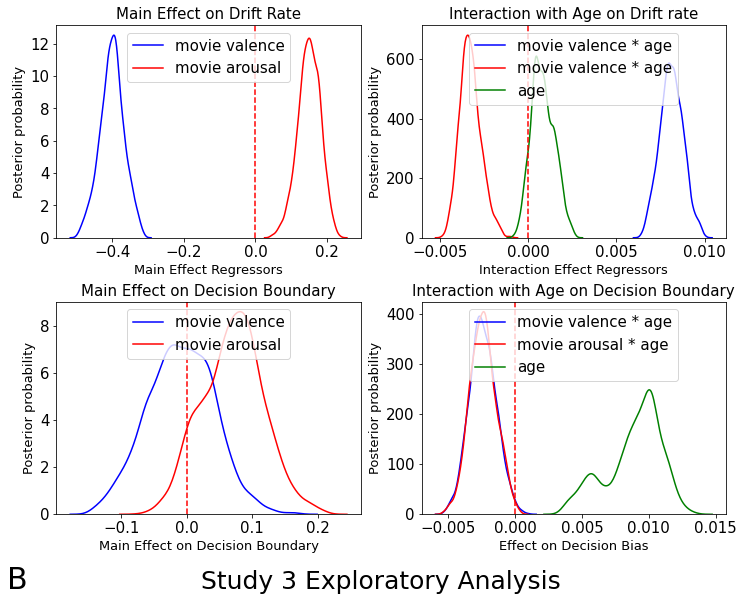

In [184]:
fig, ax = plt.subplots(2,2,figsize=(12,9))


sns.kdeplot(v_movie_valence,ax=ax[0,0], label="movie valence", color='b')
sns.kdeplot(v_movie_arousal,ax=ax[0,0], label="movie arousal", color='red')
ax[0,0].legend(loc='upper center')
ax[0,0].axvline(x=0,c = 'r', ls='--')
ax[0,0].set_xlabel('Main Effect Regressors', fontsize=13)
ax[0,0].set_ylabel('Posterior probability', fontsize=13)
ax[0,0].set_title('Main Effect on Drift Rate', fontsize=15)


sns.kdeplot(v_age_movie_valence,ax=ax[0,1], label="movie valence * age", color='b')
sns.kdeplot(v_age_movie_arousal,ax=ax[0,1], label="movie valence * age", color='red')
sns.kdeplot(v_age,ax=ax[0,1], label="age", color='green')
ax[0,1].legend(loc='upper center')
ax[0,1].axvline(x=0,c = 'r', ls='--')
ax[0,1].set_xlabel('Interaction Effect Regressors', fontsize=13)
ax[0,1].set_ylabel('Posterior probability', fontsize=13)
ax[0,1].set_title('Interaction with Age on Drift rate', fontsize=15)


sns.kdeplot(a_movie_valence,ax=ax[1,0], label="movie valence", color='b')
sns.kdeplot(a_movie_arousal,ax=ax[1,0], label="movie arousal", color='red')
ax[1,0].legend(loc='upper center')
ax[1,0].axvline(x=0,c = 'r', ls='--')
ax[1,0].set_xlabel('Main Effect on Decision Boundary', fontsize=13)
ax[1,0].set_ylabel('Posterior probability', fontsize=13)
ax[1,0].set_title('Main Effect on Decision Boundary', fontsize=15)


sns.kdeplot(a_age_movie_valence,ax=ax[1,1], label="movie valence * age", color='b')
sns.kdeplot(a_age_movie_arousal,ax=ax[1,1], label="movie arousal * age", color='red')
sns.kdeplot(a_age,ax=ax[1,1], label="age", color='green')
ax[1,1].legend(loc='upper center')
ax[1,1].axvline(x=0,c = 'r', ls='--')
ax[1,1].set_xlabel('Effect on Decision Bias', fontsize=13)
ax[1,1].set_ylabel('Posterior probability', fontsize=13)
ax[1,1].set_title('Interaction with Age on Decision Boundary', fontsize=15)


plt.subplots_adjust(wspace=0.2, hspace=.3)


fig.text(0.08, 0.01, 'B', ha='center',fontsize=30)
fig.text(0.5, 0.01, 'Study 3 Exploratory Analysis', ha='center',fontsize=25)

plt.savefig('Figure4B.png', dpi=300)

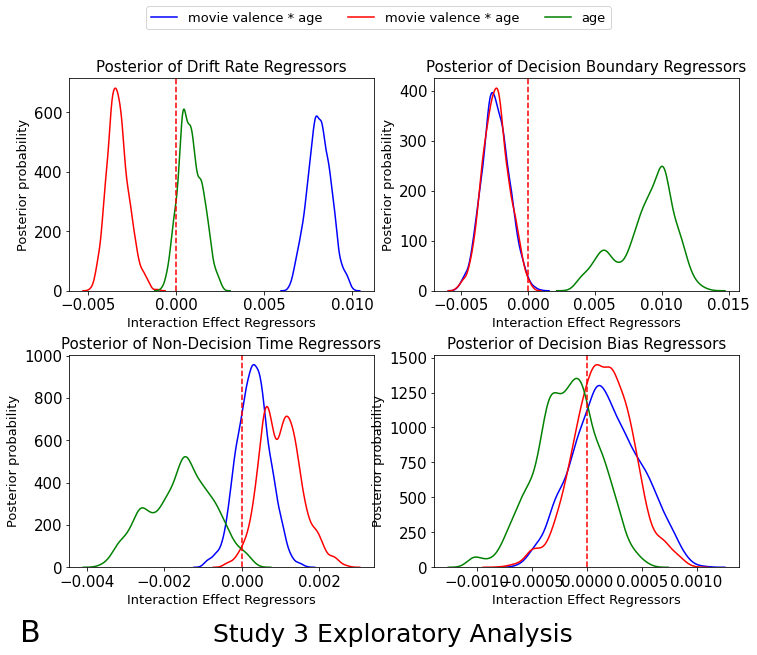

In [186]:
fig, ax = plt.subplots(2,2,figsize=(12,9))


sns.kdeplot(v_age_movie_valence,ax=ax[0,0], label="movie valence * age", color='b')
sns.kdeplot(v_age_movie_arousal,ax=ax[0,0], label="movie valence * age", color='red')
sns.kdeplot(v_age,ax=ax[0,0], label="age", color='green')
ax[0,0].axvline(x=0,c = 'r', ls='--')
ax[0,0].set_xlabel('Interaction Effect Regressors', fontsize=13)
ax[0,0].set_ylabel('Posterior probability', fontsize=13)
ax[0,0].set_title('Posterior of Drift Rate Regressors', fontsize=15)




sns.kdeplot(a_age_movie_valence,ax=ax[0,1], label="movie valence * age", color='b')
sns.kdeplot(a_age_movie_arousal,ax=ax[0,1], label="movie valence * age", color='red')
sns.kdeplot(a_age,ax=ax[0,1], label="age", color='green')
ax[0,1].axvline(x=0,c = 'r', ls='--')
ax[0,1].set_xlabel('Interaction Effect Regressors', fontsize=13)
ax[0,1].set_ylabel('Posterior probability', fontsize=13)
ax[0,1].set_title('Posterior of Decision Boundary Regressors', fontsize=15)




sns.kdeplot(t_age_movie_valence,ax=ax[1,0], label="movie valence * age", color='b')
sns.kdeplot(t_age_movie_arousal,ax=ax[1,0], label="movie valence * age", color='red')
sns.kdeplot(t_age,ax=ax[1,0], label="age", color='green')
ax[1,0].axvline(x=0,c = 'r', ls='--')
ax[1,0].set_xlabel('Interaction Effect Regressors', fontsize=13)
ax[1,0].set_ylabel('Posterior probability', fontsize=13)
ax[1,0].set_title('Posterior of Non-Decision Time Regressors', fontsize=15)



sns.kdeplot(z_age_movie_valence,ax=ax[1,1], label="movie valence * age", color='b')
sns.kdeplot(z_age_movie_arousal,ax=ax[1,1], label="movie valence * age", color='red')
sns.kdeplot(z_age,ax=ax[1,1], label="age", color='green')
ax[1,1].axvline(x=0,c = 'r', ls='--')
ax[1,1].set_xlabel('Interaction Effect Regressors', fontsize=13)
ax[1,1].set_ylabel('Posterior probability', fontsize=13)
ax[1,1].set_title('Posterior of Decision Bias Regressors', fontsize=15)




plt.subplots_adjust(wspace=0.2, hspace=.3)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size': 13})

fig.text(0.08, 0.01, 'B', ha='center',fontsize=30)
fig.text(0.5, 0.01, 'Study 3 Exploratory Analysis', ha='center',fontsize=25)

plt.savefig('Figure4B.png', dpi=300)